In [1]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00:00:0100:01
  Attempting unin

In [2]:
import os
import cv2
import math
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
from captum.attr import LayerGradCam, DeepLift

In [3]:
IMG_SIZE = (768, 768)
BATCH_SIZE = 4
NUM_CLASSES = 14

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR_TRAIN = '/kaggle/input/grand-xray-slam-division-b/train2/'

In [4]:
# load train.csv
try:
    train_df = pd.read_csv('/kaggle/input/grand-xray-slam-division-b/train2.csv')
    print(f"Loaded train1.csv with {len(train_df)} rows")
except FileNotFoundError:
    print("Error: train2.csv not found. Ensure dataset is attached.")
    raise

label_columns = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]

missing_cols = [col for col in label_columns if col not in train_df.columns]
if missing_cols:
    raise KeyError(f"Missing columns: {missing_cols}")

subset_frac = 1
df_small = train_df.sample(frac=subset_frac, random_state=42)

train_data, val_test_data = train_test_split(df_small, test_size=0.15, random_state=42)

val_data, test_data = train_test_split(val_test_data, test_size=0.33, random_state=42)

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")

Loaded train1.csv with 108494 rows
Train samples: 92219, Validation samples: 10904, Test samples: 5371


In [5]:
transform = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE[0]),
    A.PadIfNeeded(min_height=IMG_SIZE[0], min_width=IMG_SIZE[1], border_mode=0),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [6]:
class ChestXRayDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_dir: str, img_size=IMG_SIZE, 
                                             label_cols=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size
        self.label_cols = label_cols
        self.transform = transform

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory {self.image_dir} not found.")

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image_name']
        img_path = os.path.join(self.image_dir, img_name)
    
        # load grayscale image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None or img.size == 0:
            img = np.zeros(self.img_size, dtype=np.uint8)
        else:
            img = cv2.resize(img, self.img_size)
    
        # make (H, W, 1) for albumentations
        img = np.expand_dims(img, axis=-1)
    
        # augmentation
        if self.transform:
            # albumentations
            img = self.transform(image=img)["image"]
        else:
            # to tensor
            img = transforms.ToTensor()(img)

        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        return img, labels

In [7]:
class CNNClassifier(nn.Module):
    def __init__(self, backbone, feature_dim, num_classes):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

In [8]:
test_dataset = ChestXRayDataset(test_data, IMAGE_DIR_TRAIN, img_size=IMG_SIZE, 
                                        label_cols=label_columns, transform=transform)
test_loader   = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                        num_workers=3, pin_memory=True)

In [9]:
# load model
backbone = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
orig_conv = backbone.features[0][0]

backbone.features[0][0] = nn.Conv2d(
    1,
    orig_conv.out_channels, 
    kernel_size=orig_conv.kernel_size,
    stride=orig_conv.stride,
    padding=orig_conv.padding,
    bias=False
)
feature_dim = backbone.classifier[1].in_features
backbone.classifier = nn.Identity()

model = CNNClassifier(backbone, feature_dim=feature_dim, num_classes=NUM_CLASSES)
model.to(DEVICE)

checkpoint_path = "/kaggle/input/best_efficientnet_v2_m_epoch_8_auc0.9162/pytorch/default/1/best_efficientnet_v2_m_epoch_8_auc0.9162.pth"
state_dict = torch.load(checkpoint_path, map_location=DEVICE)

model.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:08<00:00, 24.4MB/s] 


<All keys matched successfully>

In [10]:
def test_probs(model):
    # model probabilities
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Test"):
            imgs = imgs.to(DEVICE, dtype=torch.float)
            labels = labels.to(DEVICE, dtype=torch.float)
    
            logits = model(imgs)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            test_preds.append(probs)
            test_labels.append(labels.cpu().numpy())
    
    test_preds = np.vstack(test_preds)
    test_labels = np.vstack(test_labels)
    
    rows = []
    for i in range(len(test_preds)):
        for class_idx in range(14):
            rows.append({
                'sample_id': i,
                'class': class_idx,
                'true_label': test_labels[i, class_idx],
                'probability': test_preds[i, class_idx],
                'error': abs(test_labels[i, class_idx] - test_preds[i, class_idx])
            })
    
    df = pd.DataFrame(rows)
    # save
    csv_filename = "test_probabilities.csv"
    df.to_csv(csv_filename, index=False)
    
    return df

In [11]:
# get predictions
df = test_probs(model)

Test:   0%|          | 0/1343 [00:00<?, ?it/s]

In [12]:
df

,sample_id,class,true_label,probability,error
0,0,0,1.0,0.567047,0.432953
1,0,1,0.0,0.502933,0.502933
2,0,2,0.0,0.275436,0.275436
3,0,3,0.0,0.275014,0.275014
4,0,4,1.0,0.716032,0.283968
...,...,...,...,...,...
75189,5370,9,0.0,0.947111,0.947111
75190,5370,10,0.0,0.000476,0.000476
75191,5370,11,0.0,0.185863,0.185863
75192,5370,12,0.0,0.032503,0.032503


In [13]:
def split_predictions_by_class(df, count):
    """
    find 3 classes (only positive):
    confident and correct predictions
    confident but incorrect predictions  
    uncertain predictions
    """

    df['predicted_label'] = (df['probability'] > 0.85).astype(int)
    df['is_correct'] = (df['predicted_label'] == df['true_label'])
    df['confidence'] = abs(df['probability'] - 0.5)
    
    results = {}
    
    for class_idx in range(14):
        class_df = df[df['class'] == class_idx].copy()
        
        # confident and correct
        correct = class_df[class_df['is_correct'] == True]
        confident_correct = correct.nlargest(count, 'probability')
        
        # confident and incorrect
        incorrect = class_df[class_df['is_correct'] == False]
        confident_incorrect = incorrect.nlargest(count, 'probability')
        
        # uncertain
        class_df['confidence'] = abs(class_df['probability'] - 0.5)
        uncertain = class_df.nsmallest(count, 'confidence')
        
        results[class_idx] = {
            'confident_correct': confident_correct,
            'confident_incorrect': confident_incorrect, 
            'uncertain': uncertain
        }
    
    return results

In [14]:
test_img_name = test_data['Image_name'].reset_index(drop=True)
position = test_data['ViewPosition'].reset_index(drop=True)
df["image_name"] = df["sample_id"].map(lambda i: test_img_name[i])
df["position"] = df["sample_id"].map(lambda i: position[i])

In [15]:
# split by class into 3 categories each
class_results = split_predictions_by_class(df, count=50)

In [16]:
means = {}

for class_idx, categories in class_results.items():
    means[class_idx] = {}
    
    for category, df in categories.items():
        means[class_idx][category] = df['probability'].agg(['mean', 'min', 'max'])
means

{0: {'confident_correct': mean    0.999282
  min     0.998853
  max     0.999840
  Name: probability, dtype: float64,
  'confident_incorrect': mean    0.979888
  min     0.953403
  max     0.998880
  Name: probability, dtype: float64,
  'uncertain': mean    0.499348
  min     0.486021
  max     0.513338
  Name: probability, dtype: float64},
 1: {'confident_correct': mean    0.999810
  min     0.999615
  max     0.999994
  Name: probability, dtype: float64,
  'confident_incorrect': mean    0.985828
  min     0.965372
  max     0.999857
  Name: probability, dtype: float64,
  'uncertain': mean    0.499605
  min     0.487791
  max     0.511709
  Name: probability, dtype: float64},
 2: {'confident_correct': mean    0.998048
  min     0.996690
  max     0.999767
  Name: probability, dtype: float64,
  'confident_incorrect': mean    0.979327
  min     0.957443
  max     0.996599
  Name: probability, dtype: float64,
  'uncertain': mean    0.500800
  min     0.479494
  max     0.520848
  Name: p

In [17]:
health_data = test_data[test_data['No Finding'] == 1]
AP = health_data[health_data['ViewPosition']=='AP']['Image_name']
PA = health_data[health_data['ViewPosition']=='PA']['Image_name']
Lat = health_data[health_data['ViewPosition']=='Lateral']['Image_name']

In [18]:
def load_raw_image(img_name, image_dir, img_size, transform=transform):
    img_path = os.path.join(image_dir, img_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(img, axis=-1)

    if transform is not None:
        img = transform(image=img)["image"]
    else:
        img = transforms.ToTensor()(img)

    return img


In [19]:
def compute_mean_image(image_names, image_dir, img_size, transform):
    # health mean image for deeplift (background)
    total = None
    count = 0

    for img_name in tqdm(image_names, desc="Processing"):
        img = load_raw_image(img_name, image_dir, img_size, transform)
        img = img.float()
        
        if total is None:
            total = img.clone()
        else:
            total += img
        
        count += 1

    if count == 0:
        raise ValueError("No images found to average.")

    mean_img = total / count

    return mean_img

In [20]:
mean_AP = compute_mean_image(AP, IMAGE_DIR_TRAIN, IMG_SIZE, transform)
mean_PA = compute_mean_image(PA, IMAGE_DIR_TRAIN, IMG_SIZE, transform)
mean_Lat = compute_mean_image(Lat, IMAGE_DIR_TRAIN, IMG_SIZE, transform)

Processing:   0%|          | 0/517 [00:00<?, ?it/s]

Processing:   0%|          | 0/859 [00:00<?, ?it/s]

Processing:   0%|          | 0/244 [00:00<?, ?it/s]

In [21]:
if torch.cuda.is_available():
    mean_AP  = mean_AP.unsqueeze(0).to(DEVICE)
    mean_PA  = mean_PA.unsqueeze(0).to(DEVICE)
    mean_Lat = mean_Lat.unsqueeze(0).to(DEVICE)

In [22]:
# mapping function
def get_baseline(position, inp_gpu):
    if position == "AP":
        return mean_AP
    elif position == "PA":
        return mean_PA
    elif position == "Lateral":
        return mean_Lat

In [23]:
def create_mask(arr, method='mean', param=None):
    # binary mask
    if method == 'mean':
        # pixels are above average
        threshold = np.mean(arr)
        return (arr > threshold).astype(np.uint8)
    
    elif method == 'mean_std':
        # pixels are above average + k*std
        k = param if param is not None else 1.0
        threshold = np.mean(arr) + k * np.std(arr)
        return (arr > threshold).astype(np.uint8)
    
    elif method == 'median':
        # median-based threshold
        factor = param if param is not None else 1.5 # default: 1.5 * median
        median_val = np.median(arr)
        threshold = median_val * factor
        return (arr > threshold).astype(np.uint8)
    else:
        raise ValueError(f"Unknown method: {method}")


def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return inter / union if union > 0 else 0.0

In [24]:
logging.getLogger('captum').setLevel(logging.ERROR)

In [25]:
# iou for gc and dl maps
results = []

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

target_layer = model.backbone.features[-1]


for class_idx, categories in class_results.items():
    for cat_name, df_cat in categories.items():

        print(f"Processing class {class_idx} {cat_name}")

        for _, row in df_cat.iterrows():
            sample_id = int(row["sample_id"])
            img_name  = row["image_name"]
            position  = row["position"]

            inp = load_raw_image(
                img_name,
                IMAGE_DIR_TRAIN,
                IMG_SIZE,
                transform=transform
            ).unsqueeze(0).to(torch.float32)

            if torch.cuda.is_available():
                inp_gpu = inp.to(DEVICE)

                # GRAD-CAM
                with torch.enable_grad():
                    gradcam = LayerGradCam(model, target_layer)

                    gc_attr = gradcam.attribute(inp_gpu, target=class_idx)  
                    gc_map = gc_attr.squeeze().detach().cpu().numpy()   # (24, 24)
                    gc_map = np.clip(gc_map, 0, None)

                del gradcam, gc_attr

                # deeplift
                with torch.enable_grad():
                    deep_lift = DeepLift(model)
                    baseline = get_baseline(position, inp_gpu)

                    dl_attr = deep_lift.attribute(
                        inp_gpu,
                        baselines=baseline,
                        target=class_idx
                    ).squeeze().detach().cpu().numpy()

                    dl_map = cv2.resize(dl_attr, (24, 24), interpolation=cv2.INTER_LINEAR)
                    dl_map = np.clip(dl_map, 0, None)

                del deep_lift, baseline, dl_attr

                # IoU
                m1_mean = create_mask(gc_map, method="mean")
                m2_mean = create_mask(dl_map, method="mean")
                iou_mean = iou(m1_mean, m2_mean)

                m1_mean_std = create_mask(gc_map, method="mean_std")
                m2_mean_std = create_mask(dl_map, method="mean_std")
                iou_mean_std = iou(m1_mean_std, m2_mean_std)
                
                m1_median = create_mask(gc_map, method="median")
                m2_median = create_mask(dl_map, method="median")
                iou_median = iou(m1_median, m2_median)
                
                results.append({
                    "class_idx": class_idx,
                    "cat_name": cat_name,
                    "sample_id": sample_id,
                    "iou_mean": iou_mean,
                    "iou_mean_std": iou_mean_std,
                    "iou_median": iou_median
                })

            else:
                raise RuntimeError("No CUDA available")

#save
df_metrics = pd.DataFrame(results)
df_metrics.to_csv("interpretability_metrics.csv", index=False)

Processing class 0 confident_correct


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Processing class 0 confident_incorrect
Processing class 0 uncertain
Processing class 1 confident_correct
Processing class 1 confident_incorrect
Processing class 1 uncertain
Processing class 2 confident_correct
Processing class 2 confident_incorrect
Processing class 2 uncertain
Processing class 3 confident_correct
Processing class 3 confident_incorrect
Processing class 3 uncertain
Processing class 4 confident_correct
Processing class 4 confident_incorrect
Processing class 4 uncertain
Processing class 5 confident_correct
Processing class 5 confident_incorrect
Processing class 5 uncertain
Processing class 6 confident_correct
Processing class 6 confident_incorrect
Processing class 6 uncertain
Processing class 7 confident_correct
Processing class 7 confident_incorrect
Processing class 7 uncertain
Processing class 8 confident_correct
Processing class 8 confident_incorrect
Processing class 8 uncertain
Processing class 9 confident_correct
Processing class 9 confident_incorrect
Processing class

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, f_oneway, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

----------iou_mean----------

Average IoU consistency
0.15834846356562438
Average IoU consistency by type of prediction:
confident_correct: 0.1635
confident_incorrect: 0.1626
uncertain: 0.1490


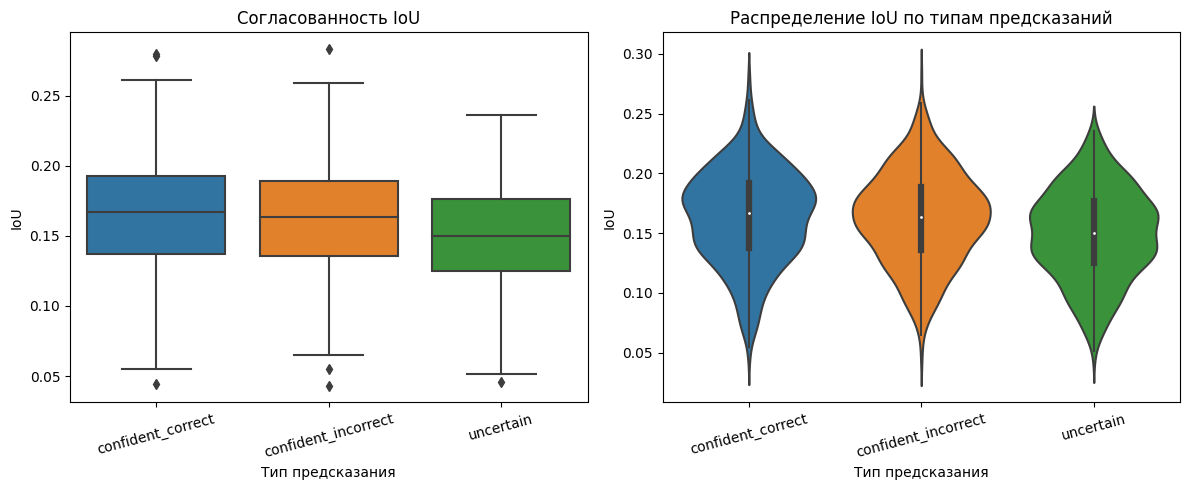

Statistics tests:
confident_correct: size = 700
confident_incorrect: size = 700
uncertain: size = 700
Kruskal-Wallis:
H = 58.6302, p = 0.000000
Mann-Whitney:
confident_correct vs confident_incorrect: U=250207.5, p=0.491180, p_adj=1.000000
confident_correct vs uncertain: U=297313.0, p=0.000000, p_adj=0.000000
confident_incorrect vs uncertain: U=292605.0, p=0.000000, p_adj=0.000000
Object class analysis
Average consistency across classes:
0: 0.1653
1: 0.1831
2: 0.1781
3: 0.1746
4: 0.1758
5: 0.1531
6: 0.1236
7: 0.1749
8: 0.1383
9: 0.1748
10: 0.1484
11: 0.1621
12: 0.1442
13: 0.1206

----------iou_mean_std----------

Average IoU consistency
0.08589061940993585
Average IoU consistency by type of prediction:
confident_correct: 0.0899
confident_incorrect: 0.0877
uncertain: 0.0800


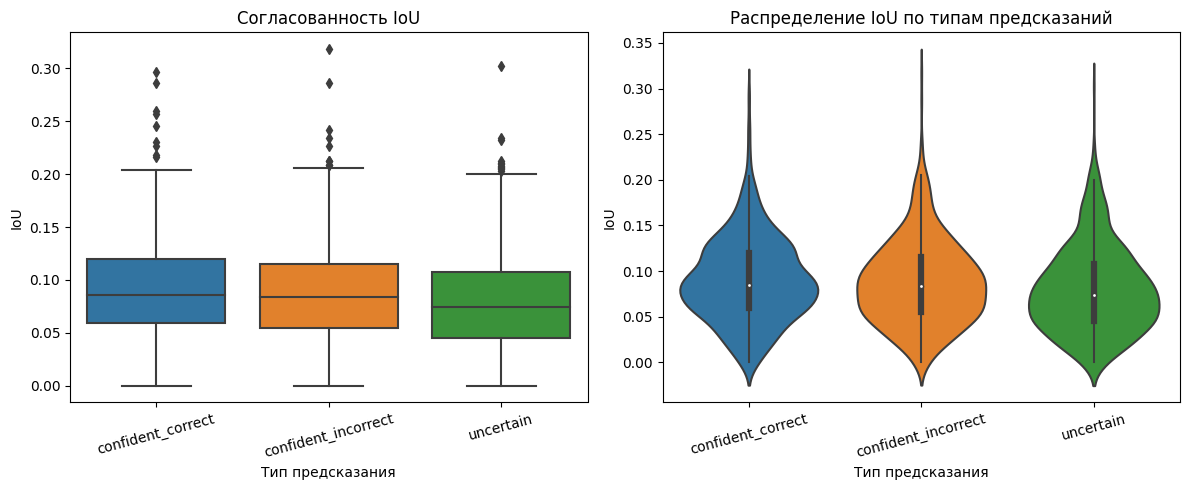

Statistics tests:
confident_correct: size = 700
confident_incorrect: size = 700
uncertain: size = 700
Kruskal-Wallis:
H = 22.6184, p = 0.000012
Mann-Whitney:
confident_correct vs confident_incorrect: U=253455.5, p=0.263621, p_adj=0.790863
confident_correct vs uncertain: U=279205.5, p=0.000006, p_adj=0.000018
confident_incorrect vs uncertain: U=271439.5, p=0.000473, p_adj=0.001419
Object class analysis
Average consistency across classes:
0: 0.0967
1: 0.0967
2: 0.0884
3: 0.0789
4: 0.0792
5: 0.0701
6: 0.0884
7: 0.0825
8: 0.0624
9: 0.1181
10: 0.0892
11: 0.0876
12: 0.0870
13: 0.0772

----------iou_median----------

Average IoU consistency
0.2027595158372451
Average IoU consistency by type of prediction:
confident_correct: 0.1986
confident_incorrect: 0.1918
uncertain: 0.2179


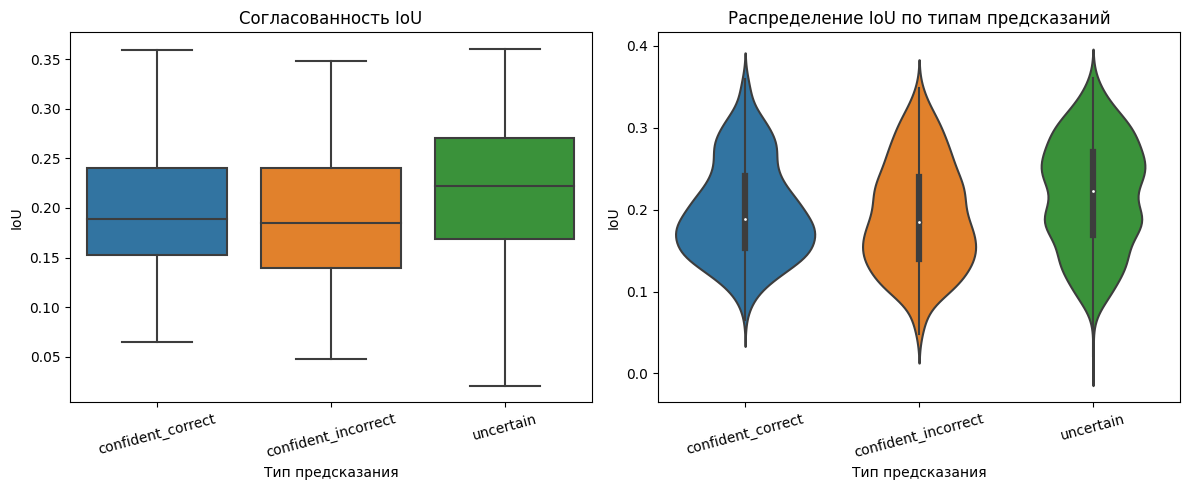

Statistics tests:
confident_correct: size = 700
confident_incorrect: size = 700
uncertain: size = 700
Kruskal-Wallis:
H = 61.5869, p = 0.000000
Mann-Whitney:
confident_correct vs confident_incorrect: U=260469.0, p=0.040842, p_adj=0.122525
confident_correct vs uncertain: U=200427.5, p=0.000000, p_adj=0.000000
confident_incorrect vs uncertain: U=189638.5, p=0.000000, p_adj=0.000000
Object class analysis
Average consistency across classes:
0: 0.1505
1: 0.2208
2: 0.1750
3: 0.2546
4: 0.1923
5: 0.1959
6: 0.2054
7: 0.1665
8: 0.2289
9: 0.1826
10: 0.2065
11: 0.1913
12: 0.2486
13: 0.2197



In [35]:
iou = ["iou_mean", "iou_mean_std", "iou_median"]

for i in iou:
    print('-'*10 + i + '-'*10 + "\n")
    print("Average IoU consistency")
    print(df_metrics[i].mean())
    print("Average IoU consistency by type of prediction:")
    for cat in df_metrics['cat_name'].unique():
        cat_data = df_metrics[df_metrics['cat_name'] == cat][i]
        print(f"{cat}: {cat_data.mean():.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='cat_name', y=i, data=df_metrics, order=['confident_correct', 'confident_incorrect', 'uncertain'])
    plt.title('Согласованность IoU')
    plt.xticks(rotation=15)
    plt.ylabel('IoU')
    plt.xlabel('Тип предсказания')
    
    plt.subplot(1, 2, 2)
    sns.violinplot(x='cat_name', y=i, data=df_metrics, order=['confident_correct', 'confident_incorrect', 'uncertain'])
    plt.title('Распределение IoU по типам предсказаний')
    plt.xticks(rotation=15)
    plt.ylabel('IoU')
    plt.xlabel('Тип предсказания')
    
    plt.tight_layout()

    plt.savefig(f'IoU_boxplot_violinplot_{i}.png', dpi=300, bbox_inches='tight') 
    plt.show()

    print("Statistics tests:")
    groups_data = {}
    for cat in df_metrics['cat_name'].unique():
        groups_data[cat] = df_metrics[df_metrics['cat_name'] == cat][i].values
        print(f"{cat}: size = {len(groups_data[cat])}")
    
    print("Kruskal-Wallis:")
    h_stat, p_kw = kruskal(*groups_data.values())
    print(f"H = {h_stat:.4f}, p = {p_kw:.6f}")
    
    print("Mann-Whitney:")
    pairs = [('confident_correct', 'confident_incorrect'),
             ('confident_correct', 'uncertain'),
             ('confident_incorrect', 'uncertain')]
    
    for cat1, cat2 in pairs:
        data1 = groups_data[cat1]
        data2 = groups_data[cat2]
        
        u_stat, p_mw = mannwhitneyu(groups_data[cat1], groups_data[cat2], alternative='two-sided')
        p_adj = min(p_mw * 3, 1.0)
        print(f"{cat1} vs {cat2}: U={u_stat:.1f}, p={p_mw:.6f}, p_adj={p_adj:.6f}")

    
    print("Object class analysis")
    class_stats = df_metrics.groupby('class_idx')[i].mean()
    print("Average consistency across classes:")
    for class_idx, value in class_stats.items():
        print(f"{class_idx}: {value:.4f}")
    print()

In [36]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [37]:
def eta_squared_two_groups(values1, values2):
    y = np.concatenate([values1, values2])
    x = np.array([0]*len(values1) + [1]*len(values2))
    grand_mean = np.mean(y)
    ssb = len(values1) * (np.mean(values1) - grand_mean)**2 + \
          len(values2) * (np.mean(values2) - grand_mean)**2
    sst = np.sum((y - grand_mean)**2)
    return ssb / sst

----------iou_mean----------

certain: mean=0.1630, std=0.0389
uncertain: mean=0.1490, std=0.0377


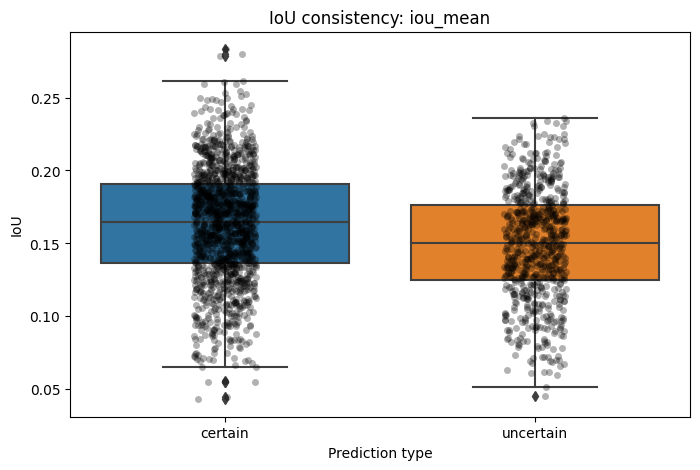

Mann–Whitney U=589918.0, p=0.000000
eta-squared (certain vs uncertain) = 0.0289 (2.9% explained variance)
----------iou_median----------

certain: mean=0.1952, std=0.0621
uncertain: mean=0.2179, std=0.0663


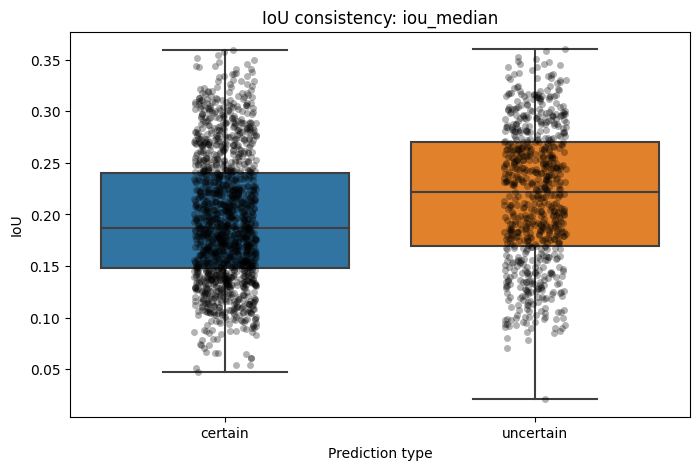

Mann–Whitney U=390066.0, p=0.000000
eta-squared (certain vs uncertain) = 0.0277 (2.8% explained variance)


In [38]:
for metric in ["iou_mean", "iou_median"]:
    print('-'*10 + metric + '-'*10 + "\n")
    
    df_metrics["binary_cat"] = df_metrics["cat_name"].replace({
        "confident_correct": "certain",
        "confident_incorrect": "certain",
        "uncertain": "uncertain"
    })
    
    for cat in ["certain", "uncertain"]:
        data = df_metrics[df_metrics["binary_cat"] == cat][metric].values
        print(f"{cat}: mean={data.mean():.4f}, std={data.std():.4f}")
    
    plt.figure(figsize=(8,5))
    sns.boxplot(x='binary_cat', y=metric, data=df_metrics, order=['certain', 'uncertain'])
    sns.stripplot(x='binary_cat', y=metric, data=df_metrics, color='black', alpha=0.3, order=['certain', 'uncertain'])
    plt.title(f'IoU consistency: {metric}')
    plt.ylabel('IoU')
    plt.xlabel('Prediction type')
    plt.show()
    
    # Mann-Whitney
    certain_data = df_metrics[df_metrics["binary_cat"] == "certain"][metric].values
    uncertain_data = df_metrics[df_metrics["binary_cat"] == "uncertain"][metric].values
    u_stat, p_mw = mannwhitneyu(certain_data, uncertain_data, alternative='two-sided')
    print(f"Mann–Whitney U={u_stat:.1f}, p={p_mw:.6f}")
    
    # eta-squared
    eta2 = eta_squared_two_groups(certain_data, uncertain_data)
    print(f"eta-squared (certain vs uncertain) = {eta2:.4f} ({eta2*100:.1f}% explained variance)")


In [39]:
stat_results = []

for metric in ["iou_mean", "iou_median"]:

    class_indices = df_metrics["class_idx"].unique()
    
    for class_id in class_indices:
        df_class = df_metrics[df_metrics["class_idx"] == class_id]
        
        certain_data = df_class[df_class["binary_cat"] == "certain"][metric].values
        uncertain_data = df_class[df_class["binary_cat"] == "uncertain"][metric].values
        
        if len(certain_data) == 0 or len(uncertain_data) == 0:
            print(f"Class {class_id}: not enough data for comparison")
            continue
        
        mean_certain, std_certain = np.mean(certain_data), np.std(certain_data)
        mean_uncertain, std_uncertain = np.mean(uncertain_data), np.std(uncertain_data)

        # Mann–Whitney
        u_stat, p_mw = mannwhitneyu(certain_data, uncertain_data, alternative='two-sided')

        # effect size if significant
        eta2 = eta_squared_two_groups(certain_data, uncertain_data) if p_mw < 0.05 else 0

        stat_results.append({
            "metric": metric,
            "class_idx": class_id,
            "mean_certain": mean_certain,
            "std_certain": std_certain,
            "mean_uncertain": mean_uncertain,
            "std_uncertain": std_uncertain,
            "u_stat": u_stat,
            "p_value": p_mw,
            "eta_squared": eta2,
        })

stat_results = pd.DataFrame(stat_results)
stat_results.to_csv("stat_class_results.csv", index=False)